In [1]:
import importlib
import requirements
importlib.reload(requirements)
from requirements import *

In [2]:
class SpatialRecurrentDataset(Dataset):
    def __init__(self, input, method:str):
        self.X, self.y = method(input)
        self.shape = tuple(self.X.shape)
        self.labels = list(set(np.array(self.y)))
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class SpatialRecurrentTransformerModel(nn.Module):
    def __init__(self, dataset:Dataset, heads, layers, dim_feedforward, dropout):
        super(SpatialRecurrentTransformerModel, self).__init__()
        self.dataset = dataset
        self.heads = heads
        self.layers = layers
        self.dim_feedforward = dim_feedforward
        self.dropout = dropout
        self.embedding = nn.Linear(dataset.shape[2], dataset.shape[2])
        self.positional_embedding = nn.Parameter(torch.rand(dataset.shape[1], dataset.shape[2]))
        transformer_layer = nn.TransformerEncoderLayer(d_model=dataset.shape[2], nhead=heads, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=layers)
        self.feedforward = nn.Sequential(nn.Linear(dataset.shape[2], dim_feedforward), nn.ReLU(), nn.Dropout(dropout), nn.Linear(dim_feedforward, dataset.shape[2]))
        self.multihead_attention = nn.MultiheadAttention(embed_dim=dataset.shape[2], num_heads=heads, dropout=dropout, batch_first=True)
        self.layer_norm = nn.LayerNorm(dataset.shape[2])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(dataset.shape[2], len(dataset.labels))
        self.train_loss, self.val_loss, self.train_accuracy, self.val_accuracy = [0, 0], [0, 0], [0, 0], [0, 0]

    def forward(self, x):
        x = self.embedding(x)
        x = x + self.positional_embedding.unsqueeze(0).expand(x.size(0), -1, -1)
        x = self.layer_norm(x)
        x = self.transformer_encoder(x)
        x = self.dropout(x)
        att, _ = self.multihead_attention(x, x, x)
        att = self.feedforward(att)
        x = x + att
        x = x.sum(dim=1)
        x = self.dropout(x)
        x = self.layer_norm(x)
        return self.fc(x)
    
    def validation(self, max, threshold):
        if self.train_accuracy[-1] >= max and self.val_accuracy[-1] >= max:
            return True
        if all(v < 0.9 for v in self.train_accuracy) and len(self.train_accuracy) > 20:
            return True
        return np.var(self.train_accuracy[-5:]) <= threshold
    
    def graph(self, save_name=''):
        tacc, vacc = self.train_accuracy, self.train_accuracy
        tlos, vlos = [i if (i <= 1.0 and i != 0.0) else 1.0 for i in self.train_loss], [i if (i <= 1.0 and i != 0.0) else 1.0 for i in self.val_loss]
        plt.figure(figsize=(14, 7))
        plt.plot(range(1, len(tacc) + 1), tacc, label='Acurácia de Treino')
        plt.plot(range(1, len(vacc) + 1), vacc, label='Acurácia de Validação')
        plt.plot(range(1, len(tlos) + 1), tlos, label='Perda de Treino')
        plt.plot(range(1, len(vlos) + 1), vlos, label='Perda de Validação')
        plt.xlabel('Épocas')
        plt.ylabel('Valor')
        plt.title('Métricas por Épocas')
        plt.legend(loc='center right', bbox_to_anchor=(1, 0.7), fontsize=12, frameon=True, fancybox=True, shadow=True)
        plt.grid(True)
        if save_name:
            plt.savefig(f'OUTPUT/GRAPHS/{save_name}.png', format='png', dpi=500)
        plt.show()
    
    def save_model(self, name:str):
        torch.save(self, f'OUTPUT/MODELS/{name}.pth')

    def train_model(self, epochs, batch_size, learning_rate, weight_decay, max=0.99, threshold=1e-6, train_ratio=0.8):
        train_dataset, val_dataset = random_split(self.dataset, [int(train_ratio * len(self.dataset)), len(self.dataset) - int(train_ratio * len(self.dataset))])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        bar = TrainingBar(model=self, train_size=len(train_loader), val_size=len(val_loader), epochs=epochs)
        for epoch in range(epochs):
            bar.reset(epoch)
            self.train()
            sum_loss = 0
            all_train_preds, all_train_labels, all_val_preds, all_val_labels = [], [], [], []
            for batch_data, batch_labels in train_loader:
                optimizer.zero_grad()
                outputs = self(batch_data)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()
                _, preds = torch.max(outputs, 1)
                all_train_preds.extend(preds.cpu().numpy())
                all_train_labels.extend(batch_labels.cpu().numpy())
                sum_loss += loss.item()
                bar.update()
            sum_loss = 0
            self.eval()
            with torch.no_grad():
                for batch_data, batch_labels in val_loader:
                    outputs = self(batch_data)
                    loss = criterion(outputs, batch_labels)
                    sum_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    all_val_preds.extend(predicted.cpu().numpy())
                    all_val_labels.extend(batch_labels.cpu().numpy())
            self.train_loss.append(sum_loss / len(train_loader))
            self.val_loss.append(sum_loss / len(val_loader))
            self.train_accuracy.append(accuracy_score(all_train_labels, all_train_preds))
            self.val_accuracy.append(accuracy_score(all_val_labels, all_val_preds))
            if self.validation(max, threshold):
                break
        bar.display()

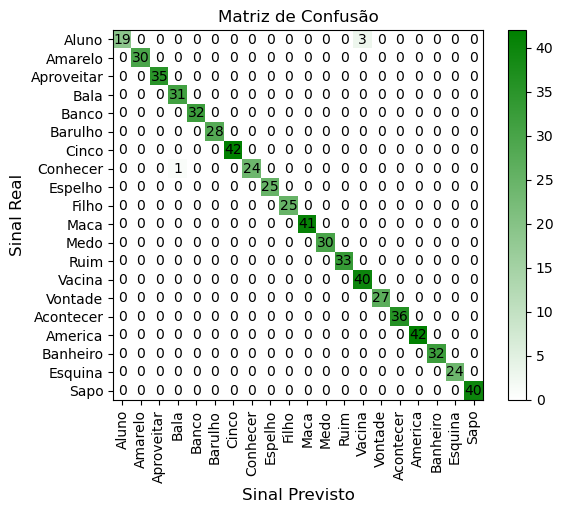

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import LinearSegmentedColormap

model = torch.load("OUTPUT/MODELS/padding_RSTmodel.pth", weights_only=False)
glossary = pd.read_csv('glossary.csv')
model.eval()
full_dataset = model.dataset
train_size = int(0.852 * len(full_dataset))
val_size = len(full_dataset) - train_size
_, val_dataset = random_split(full_dataset, [train_size, val_size])
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
all_preds = []
all_labels = []
with torch.no_grad():
    for data, labels in val_loader:
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
conf_matrix = confusion_matrix(all_labels, all_preds)
labels = glossary.set_index('ID')['SIGNAL'].tolist()
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
cmap = LinearSegmentedColormap.from_list("custom_cmap", ['white', 'green'])
disp.plot(cmap=cmap, xticks_rotation='vertical', text_kw={'color':'black'})
disp.ax_.set_xlabel("Sinal Previsto", fontsize=12)
disp.ax_.set_ylabel("Sinal Real", fontsize=12)
plt.title("Matriz de Confusão")
plt.show()

In [42]:
EPOCHS = 100
BATCH = 16
MAX = 0.995
HEADS = 86
LAYERS = 8
DFF = 2752
DROPOUT = 0.1
LR = 9e-5
WD = 2e-4
dataset = torch.load("OUTPUT/TENSORS/padding.pt", weights_only=False)
model = SignActionTransformer(dataset, heads=HEADS, layers=LAYERS, dim_feedforward=DFF, dropout=DROPOUT)
model.train_model(epochs=EPOCHS, batch_size=BATCH, learning_rate=LR, weight_decay=WD, max=MAX)

Epoch 2/100:   0%|          | 1/217 [00:01<04:33,  1.27s/it, ACC(train)=0.1558, ACC(val)=0.2786, LOSS(train)=0.5459, LOSS(val)=2.1539, DIFF=0.2172]  

KeyboardInterrupt: 

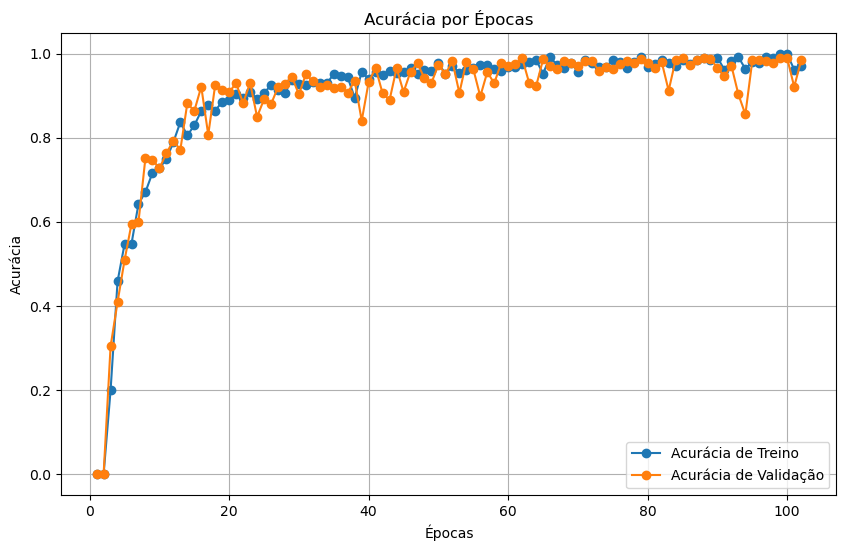

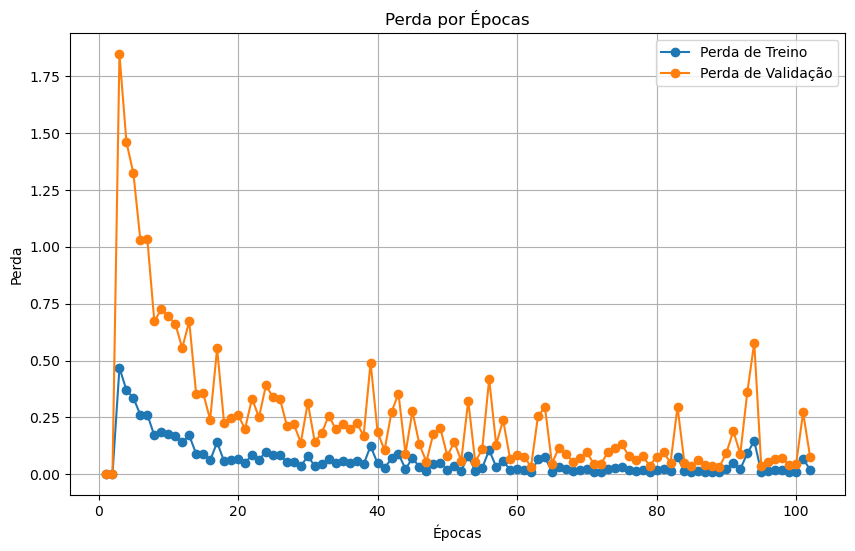

In [31]:
model.graph('dtw_rst')
model.save_model('dtw_RSTmodel')

(86, 8, 2752, 0.1, 9e-05, 0.0002)


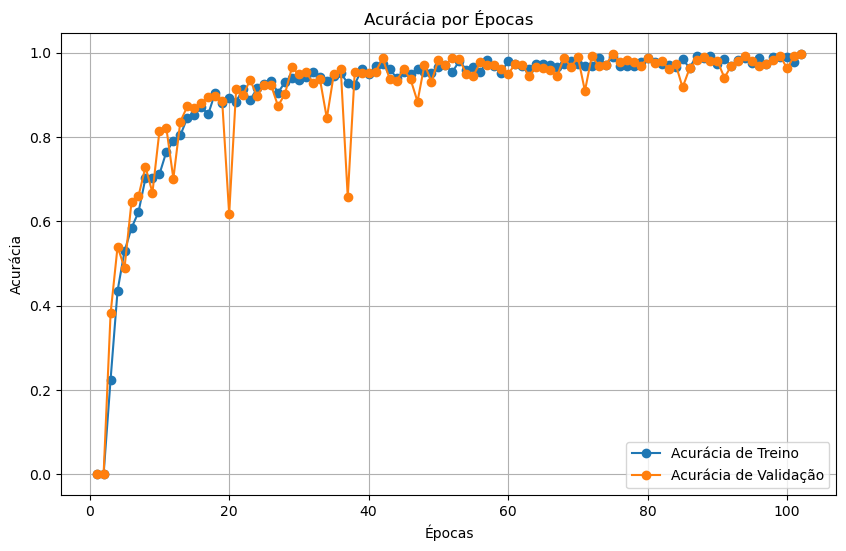

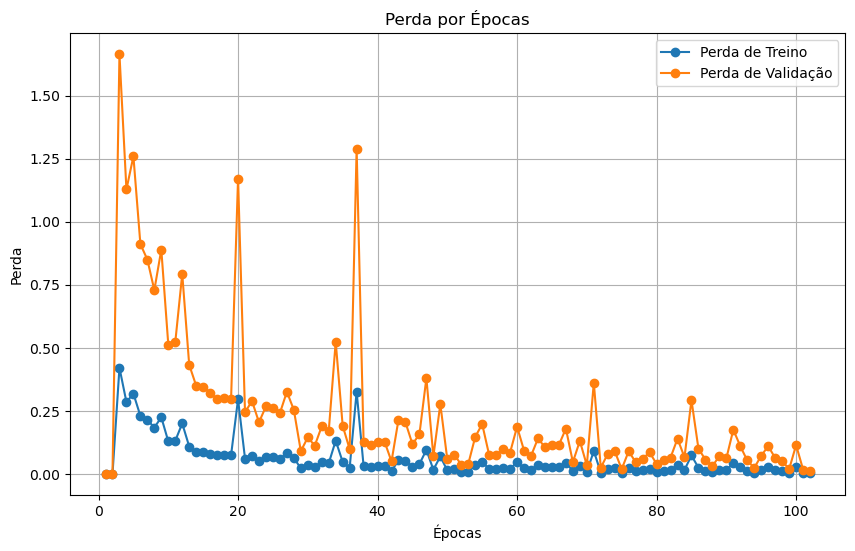

In [ ]:
EPOCHS = 100
BATCH = 16
MAX = 0.995
HEADS = [4, 86]
LAYERS = [6, 8, 10]
DFF = [688, 1376, 2752]
DROPOUT = [0.1, 0.2, 0.3]
LR = [9e-5, 1e-4, 2e-4]
WD = [9e-5, 1e-4, 2e-4]
combinations = list(itertools.product(HEADS, LAYERS, DFF, DROPOUT, LR, WD))
random.shuffle(combinations)
dataset = torch.load("OUTPUT/TENSORS/interpolate.pt", weights_only=False)
for combination in combinations:
    model = SpatialRecurrentTransformerModel(dataset, heads=combination[0], layers=combination[1], dim_feedforward=combination[2], dropout=combination[3])
    model.train_model(epochs=EPOCHS, batch_size=BATCH, learning_rate=combination[4], weight_decay=combination[5], max=MAX)
    if model.val_accuracy[-1] >= MAX and model.val_accuracy[-1] >= MAX:
        print(combination)
        model.graph('interpolate_rst')
        model.save_model('interpolate_RSTmodel2')
        break